# Install packages

In [1]:
!pip install meteostat

In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install qolmat

  Using cached cloudpickle-3.1.0-py3-none-any.whl.metadata (7.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 1.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 992.7 kB/s eta 0:00:0000:0100:01
Using cached cloudpickle-3.1.0-py3-none-any.whl (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 945.8 kB/s eta 0:00:0000:01:010m
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.2
    Uninstalling numpy-2.1.2:
      Successfully uninstalled numpy-2.1.2
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install vacances_scolaires_france

Note: you may need to restart the kernel to use updated packages.


In [7]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from meteostat import Point, Daily
import holidays
from jours_feries_france import JoursFeries
from vacances_scolaires_france import SchoolHolidayDates
import datetime

# Set plot style
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from qolmat.imputations import imputers

# Load the data

In [8]:
test_path = "https://raw.githubusercontent.com/Trung-Dan-Phan/kaggle_time_series/refs/heads/eda/data/test.csv"
train_path = "https://raw.githubusercontent.com/Trung-Dan-Phan/kaggle_time_series/refs/heads/eda/data/train.csv"

In [9]:
# Load Data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# 2. Preprocessing

#### Date and Time Features
- [ ] **Extract Date Features**: Extract year, month, day, and hour from the timestamp for each entry.
- [ ] **Cyclic Features**: Add cyclic features for hour and month using sine and cosine transformations.

#### Lag and Rolling Features
- [ ] **Lagged Values**: Create lagged features for each pollutant (1, 24, 168 hours to capture short, daily, and weekly patterns).
- [ ] **Rolling Statistics**: Add rolling mean, rolling standard deviation, and rolling min/max features to smooth trends.

#### Handle Missing Values
- [ ] **Impute Missing Values**: Choose and implement a strategy (e.g., forward-fill, backward-fill, interpolation) for missing data in each pollutant.
- [ ] **Drop or Flag Missing Rows**: If a significant portion of the data is missing, consider dropping those rows or creating an indicator feature to mark them.

#### External Weather Data (Optional but Recommended)
- [ ] **Incorporate Weather Data**: If available, obtain weather data for Paris (temperature, humidity, wind speed).
- [ ] **Merge with Pollutant Data**: Align weather data with your time series dataset based on the timestamp.

#### Data Scaling
- [ ] **Scale Features**: Use standard scaling or min-max scaling for numerical features, especially for pollutants and weather variables (if any).

#### Target Preparation
- [ ] **Prepare Target Variables**: Shift the pollutant columns to create target variables aligned with the forecasting horizon (e.g., next hour, next day).
- [ ] **Split Data**: Divide the data into training and validation sets, ensuring the split respects the time sequence.




# fix the missing values

refer to [qolmat, tsa](https://qolmat.readthedocs.io/en/latest/generated/qolmat.imputations.imputers.ImputerInterpolation.html#qolmat.imputations.imputers.ImputerInterpolation)

In [10]:
# Handling Missing Values

# Replace inf/-inf with NaN (if any)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values (using median as it's robust to outliers)
#imputer = SimpleImputer(strategy='median')
#train_df = pd.DataFrame(imputer.fit_transform(train_df), columns=train_df.columns, index=train_df.index)

In [11]:
train_df.head(2)

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
0,2020-01-01 00,42.9,0.718,15.7,73.1,64.4
1,2020-01-01 01,33.6,0.587,10.1,74.8,66.0


## find the best way filling

In [13]:
cols = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10',
       'valeur_PM25']
def check_filling_result(df=train_df, fixed_df=""):
    for col in cols:
        plt.figure(figsize=(20, 12))

        # First subplot in blue
        plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st plot
        train_df[col].plot(kind='line', color='blue', title=f"Train Data - Column '{col}' (Blue)")
        plt.xlabel("Index")
        plt.ylabel("Value")

        # Second subplot in red
        plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd plot
        fixed_df[col].plot(kind='line', color='red', title="Fixed Train Data - Column '{col}' (Red)")
        plt.xlabel("Index")
        plt.ylabel("Value")

        # Display the plots
        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()


should directly cut some values

In [14]:
import pandas as pd

# Assuming the DataFrame is already loaded and named `df`
# Sample structure based on the image:
# df = pd.read_csv('your_file.csv')  # Replace with your actual file loading method

# Create empty lists to store results
def count_consecutive_nulls(df=train_df, date_col = 'id', target_col=''):
    start_dates = []
    end_dates = []
    null_counts = []

    # Track consecutive nulls
    null_count = 0
    start_date = None

    # Iterate over the DataFrame
    for i, row in df.iterrows():
        if pd.isna(row[target_col]):
            # If null, increase the count and set the start date if it's the first in the sequence
            if null_count == 0:
                start_date = row[date_col]  # Store the start date of the null sequence
            null_count += 1
            end_date = row[date_col]  # Continuously update end date for each null in the sequence
        else:
            # If not null and there was a sequence of nulls, store the result
            if null_count > 0:
                start_dates.append(start_date)
                end_dates.append(end_date)
                null_counts.append(null_count)
                # Reset count and start date
                null_count = 0
                start_date = None

    # Check if there's an ongoing sequence at the end of the loop
    if null_count > 0:
        start_dates.append(start_date)
        end_dates.append(end_date)
        null_counts.append(null_count)

    # Compile the result into a dictionary
    result = {"start_date": start_dates, "end_date": end_dates, "null_num": null_counts}

    # Convert to DataFrame for easier visualization if needed
    result_df = pd.DataFrame(result)
    # Convert to DataFrame for easier visualization if needed
    result_df = pd.DataFrame(result)
    result_df = result_df.sort_values(by='null_num', ascending=False)
    result_df['percentage'] = result_df['null_num']/df.shape[0]*100
    print(result_df.head(5))


In [15]:
for target in cols:
    print(f'{target}')
    count_consecutive_nulls(target_col=target)
    print("\n")

valeur_NO2
       start_date       end_date  null_num  percentage
56  2024-07-31 15  2024-08-14 09       331    1.669778
62  2024-09-01 02  2024-09-03 22        69    0.348081
50  2024-06-25 18  2024-06-26 22        29    0.146295
10  2022-10-17 23  2022-10-18 23        25    0.126116
59  2024-08-26 13  2024-08-27 10        22    0.110982


valeur_CO
       start_date       end_date  null_num  percentage
6   2022-09-15 17  2022-09-26 10       258    1.301518
19  2023-08-11 18  2023-08-16 11       114    0.575090
18  2023-07-14 01  2023-07-17 07        79    0.398527
0   2022-06-28 12  2022-06-29 12        25    0.126116
23  2024-02-22 13  2024-02-23 10        22    0.110982


valeur_O3
       start_date       end_date  null_num  percentage
12  2023-04-13 08  2023-04-14 12        29    0.146295
23  2024-02-22 13  2024-02-23 10        22    0.110982
27  2024-07-03 13  2024-07-04 07        19    0.095848
5   2022-09-13 15  2022-09-14 08        18    0.090804
13  2023-04-27 14  2023-04-28 

only keep the data after 2022 june 1

In [16]:
train_df = train_df.loc[pd.to_datetime(train_df['id'])>='2022-06-01']
for target in cols:
    print(target)
    count_consecutive_nulls(target_col=target)
    print("\n")

valeur_NO2
       start_date       end_date  null_num  percentage
56  2024-07-31 15  2024-08-14 09       331    1.669778
62  2024-09-01 02  2024-09-03 22        69    0.348081
50  2024-06-25 18  2024-06-26 22        29    0.146295
10  2022-10-17 23  2022-10-18 23        25    0.126116
59  2024-08-26 13  2024-08-27 10        22    0.110982


valeur_CO
       start_date       end_date  null_num  percentage
6   2022-09-15 17  2022-09-26 10       258    1.301518
19  2023-08-11 18  2023-08-16 11       114    0.575090
18  2023-07-14 01  2023-07-17 07        79    0.398527
0   2022-06-28 12  2022-06-29 12        25    0.126116
23  2024-02-22 13  2024-02-23 10        22    0.110982


valeur_O3
       start_date       end_date  null_num  percentage
12  2023-04-13 08  2023-04-14 12        29    0.146295
23  2024-02-22 13  2024-02-23 10        22    0.110982
27  2024-07-03 13  2024-07-04 07        19    0.095848
5   2022-09-13 15  2022-09-14 08        18    0.090804
13  2023-04-27 14  2023-04-28 

### find the best filling methods using qolmat

In [17]:
from qolmat.benchmark import comparator, missing_patterns

In [22]:
# impute and compare
imputer_interpol = imputers.ImputerInterpolation(method="linear")
imputer_res = imputers.ImputerResiduals(period=24, model_tsa="additive")
# imputer_rpca = imputers.ImputerRpcaNoisy()
imputer_mce = imputers.ImputerMICE()
imputer_em = imputers.ImputerEM(columnwise=False)
imputer_locf = imputers.ImputerLOCF()

In [14]:

dict_imputers = {
      "interpolation": imputer_interpol,
      "residual": imputer_res,
      #"rpca": imputer_rpca,
      "mce": imputer_mce,
      "em": imputer_em,
      "locf": imputer_locf,
  }

generator_holes = missing_patterns.EmpiricalHoleGenerator(n_splits=4, ratio_masked=0.1)
comparison = comparator.Comparator(
      dict_imputers,
      cols,
      generator_holes = generator_holes,
      metrics = ["mae"],
  )
results = comparison.compare(train_df)
results.style.highlight_min(color="lightsteelblue", axis=1)

Testing model: interpolation...done.
Testing model: residual...done.
Testing model: mce...done.
Testing model: em...done.
Testing model: locf...done.


conclusion:  
NO2: em  
CO: mce  
O3: residual  
PM10: em  
PM25: residual  


In [41]:
train_df.columns

Index(['id', 'valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10',
       'valeur_PM25'],
      dtype='object')

In [45]:
fixed_train_df = train_df[:]

In [46]:

fixed_train_df['valeur_CO'] = imputer_mce.fit_transform(train_df[['valeur_CO']])
fixed_train_df['valeur_O3'] = imputer_res.fit_transform(train_df[['valeur_O3']])
fixed_train_df['valeur_PM25'] = imputer_res.fit_transform(train_df[['valeur_PM25']])

In [97]:
#  gotta use mce for NO, PM10, otherwise there would be considerble number of negative values
fixed_train_df['valeur_NO2'] = imputer_mce.fit_transform(train_df[['valeur_NO2']])
fixed_train_df['valeur_PM10'] = imputer_mce.fit_transform(train_df[['valeur_PM10']])

In [98]:
train_df

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
21168,2022-06-01 00,16.4,0.148,67.4,10.2,4.1
21169,2022-06-01 01,12.3,0.140,71.9,15.7,5.2
21170,2022-06-01 02,12.1,0.140,69.2,8.4,3.5
21171,2022-06-01 03,24.9,0.155,51.0,11.8,4.9
21172,2022-06-01 04,35.2,0.190,38.2,16.0,5.8
...,...,...,...,...,...,...
40986,2024-09-03 18,NaN,0.222,55.1,12.0,5.3
40987,2024-09-03 19,NaN,0.245,48.2,13.4,7.0
40988,2024-09-03 20,NaN,0.234,44.5,12.4,7.1
40989,2024-09-03 21,NaN,0.225,25.9,10.6,5.4


In [99]:
fixed_train_df

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
21168,2022-06-01 00,16.400000,0.148,67.4,10.2,4.1
21169,2022-06-01 01,12.300000,0.140,71.9,15.7,5.2
21170,2022-06-01 02,12.100000,0.140,69.2,8.4,3.5
21171,2022-06-01 03,24.900000,0.155,51.0,11.8,4.9
21172,2022-06-01 04,35.200000,0.190,38.2,16.0,5.8
...,...,...,...,...,...,...
40986,2024-09-03 18,20.613356,0.222,55.1,12.0,5.3
40987,2024-09-03 19,20.613356,0.245,48.2,13.4,7.0
40988,2024-09-03 20,20.613356,0.234,44.5,12.4,7.1
40989,2024-09-03 21,20.613356,0.225,25.9,10.6,5.4


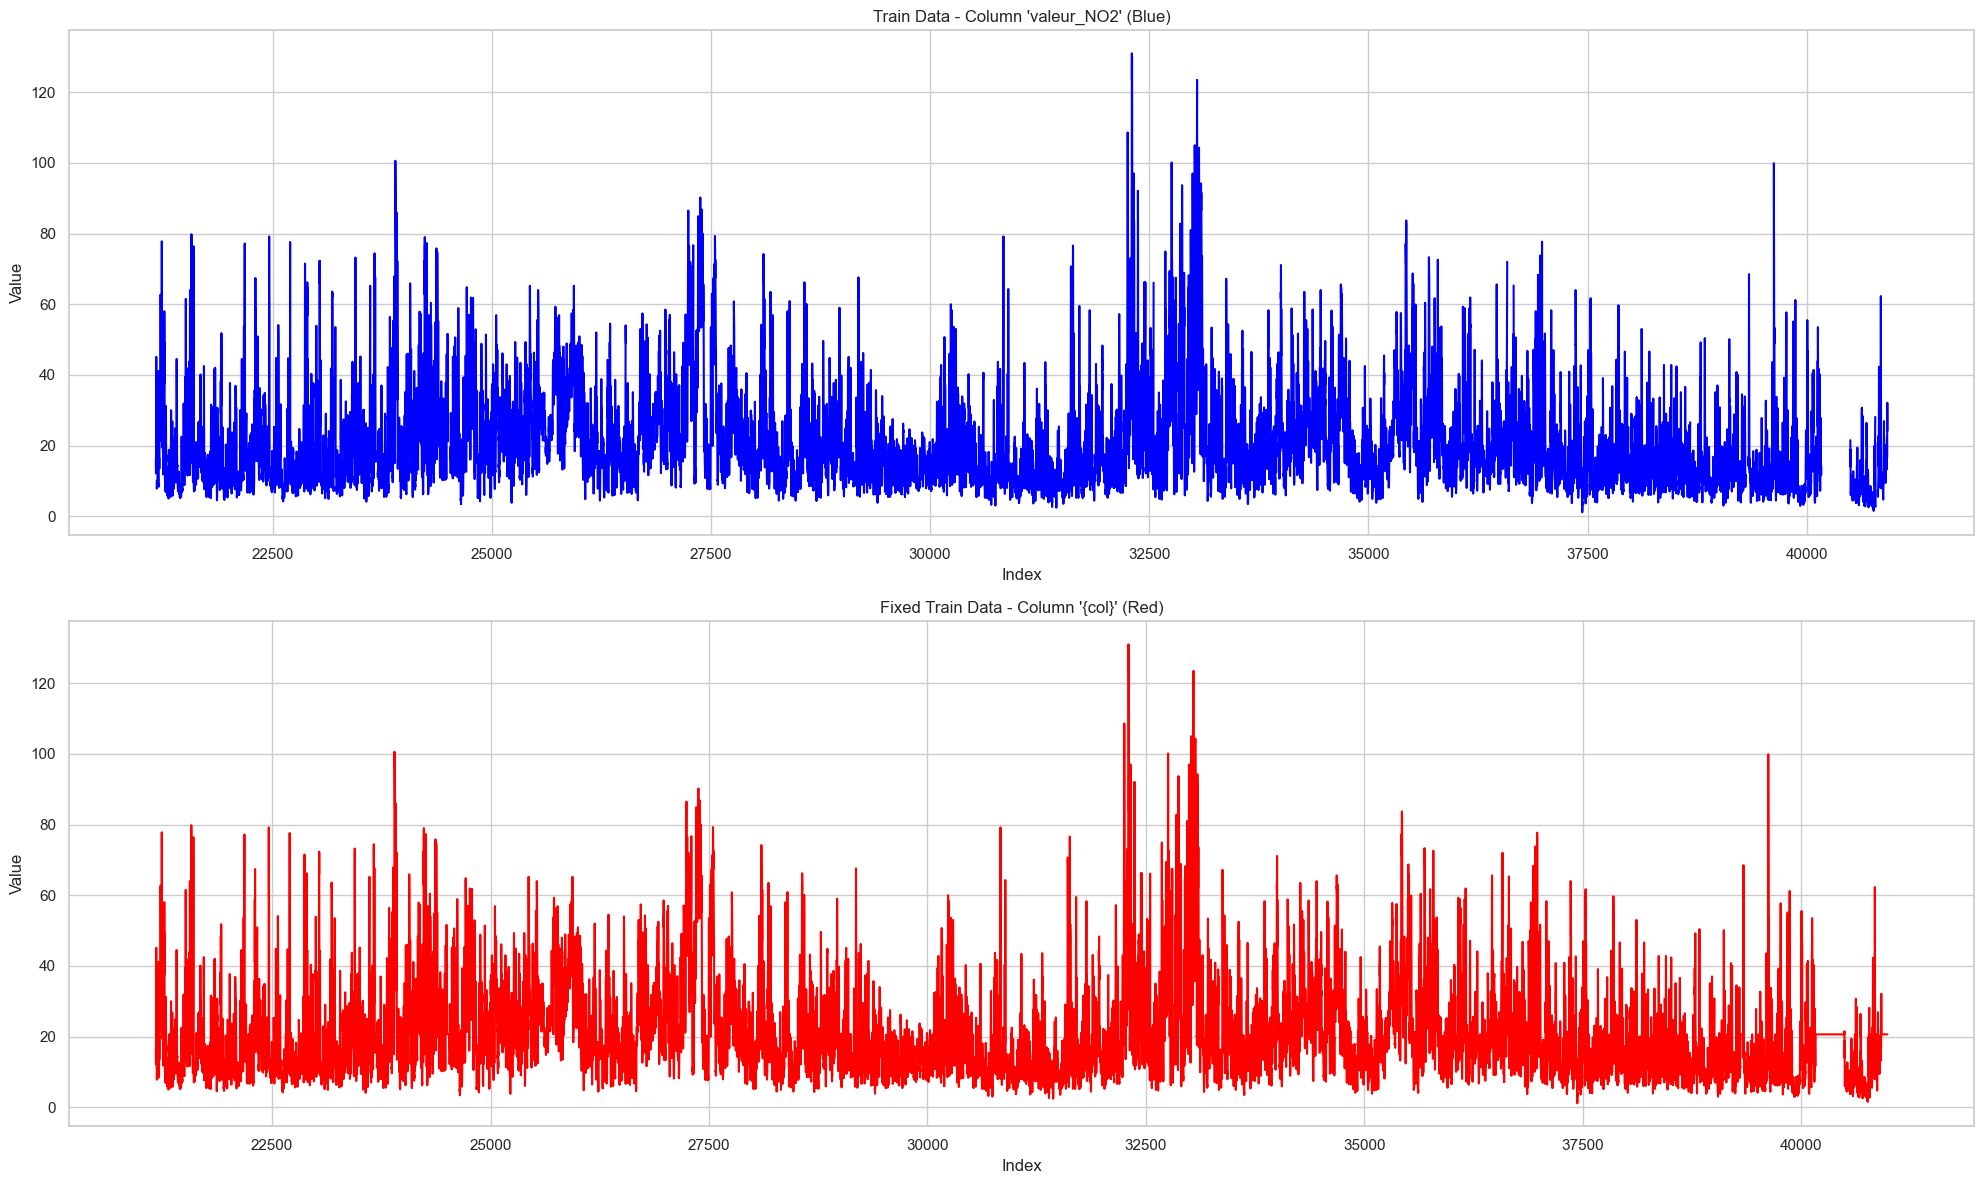

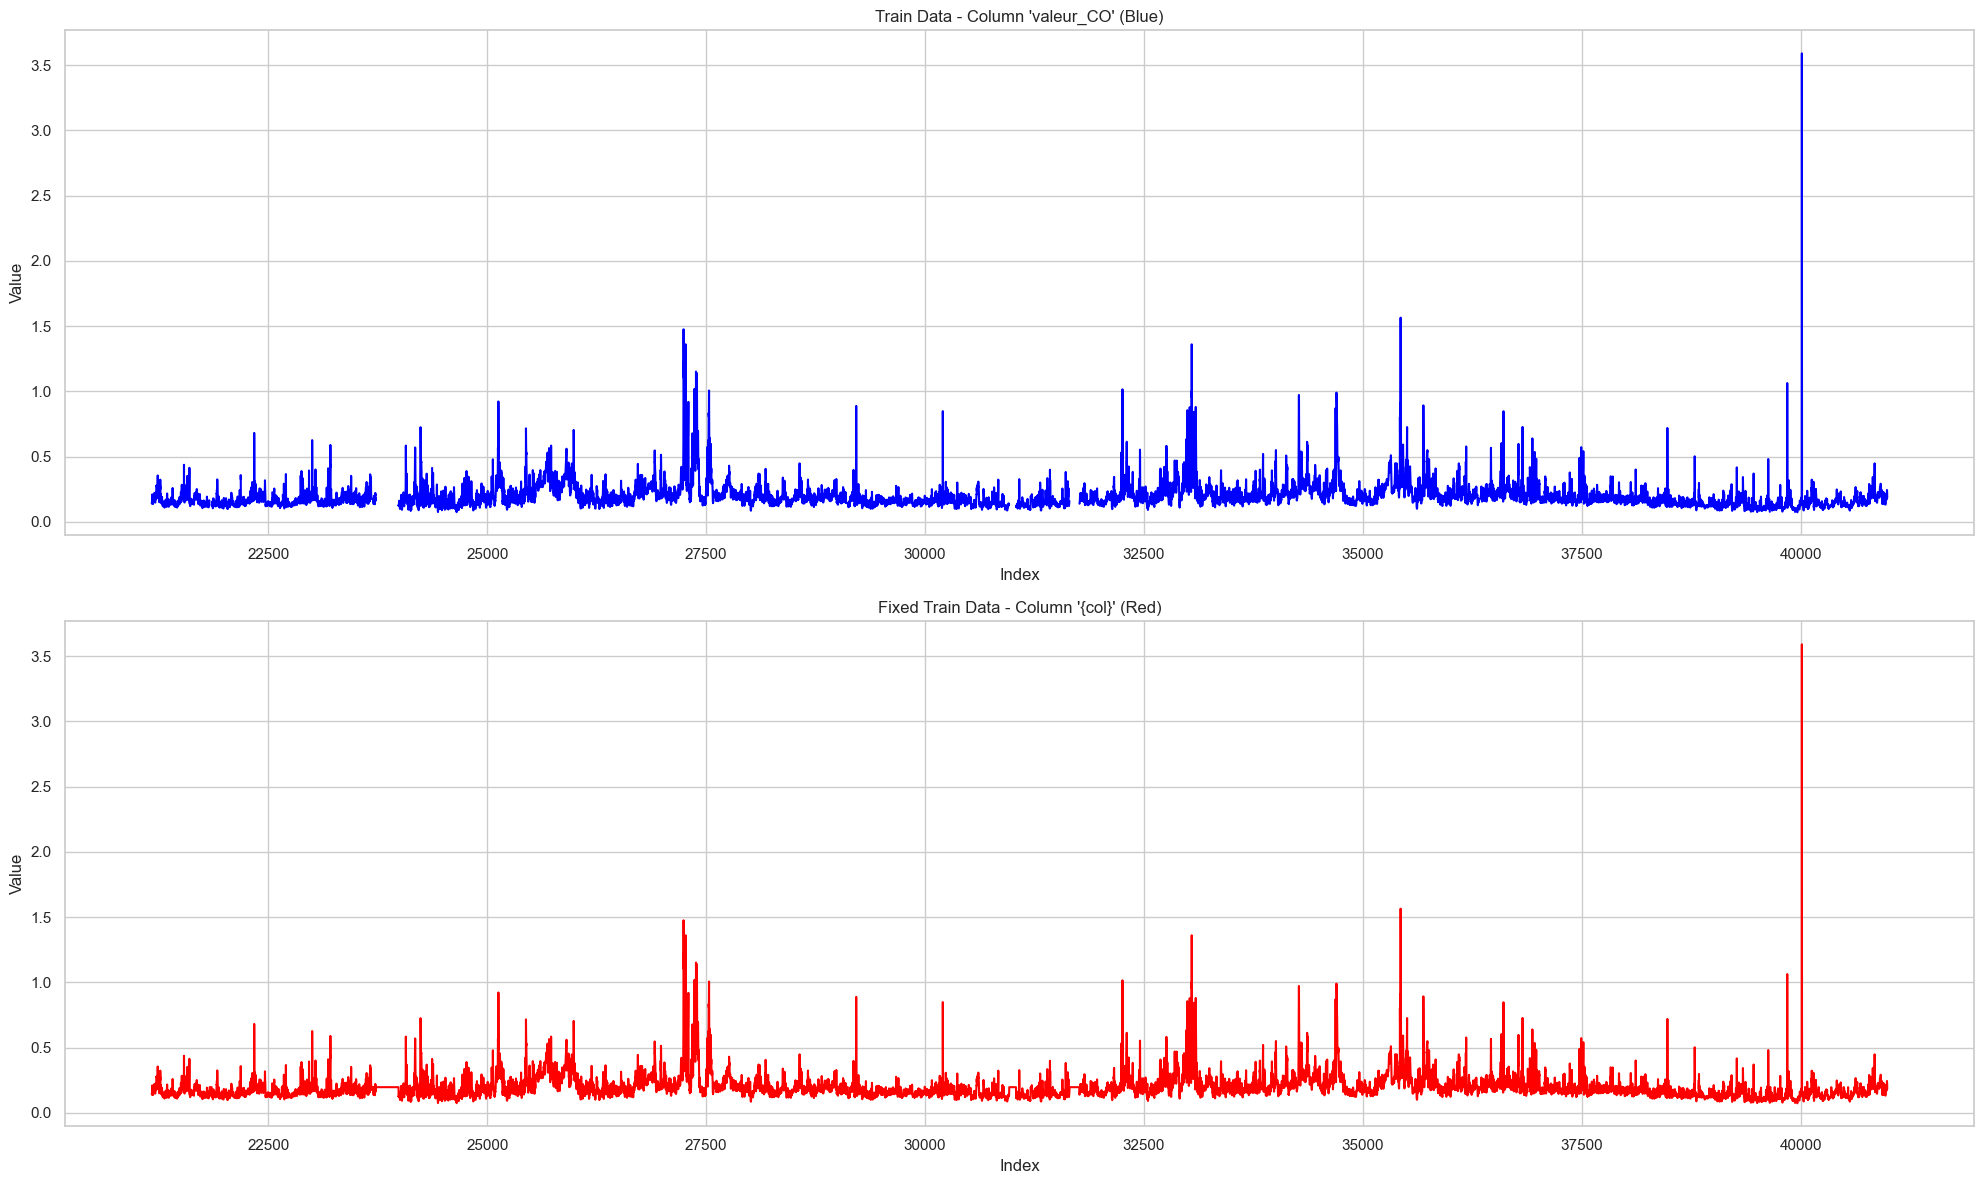

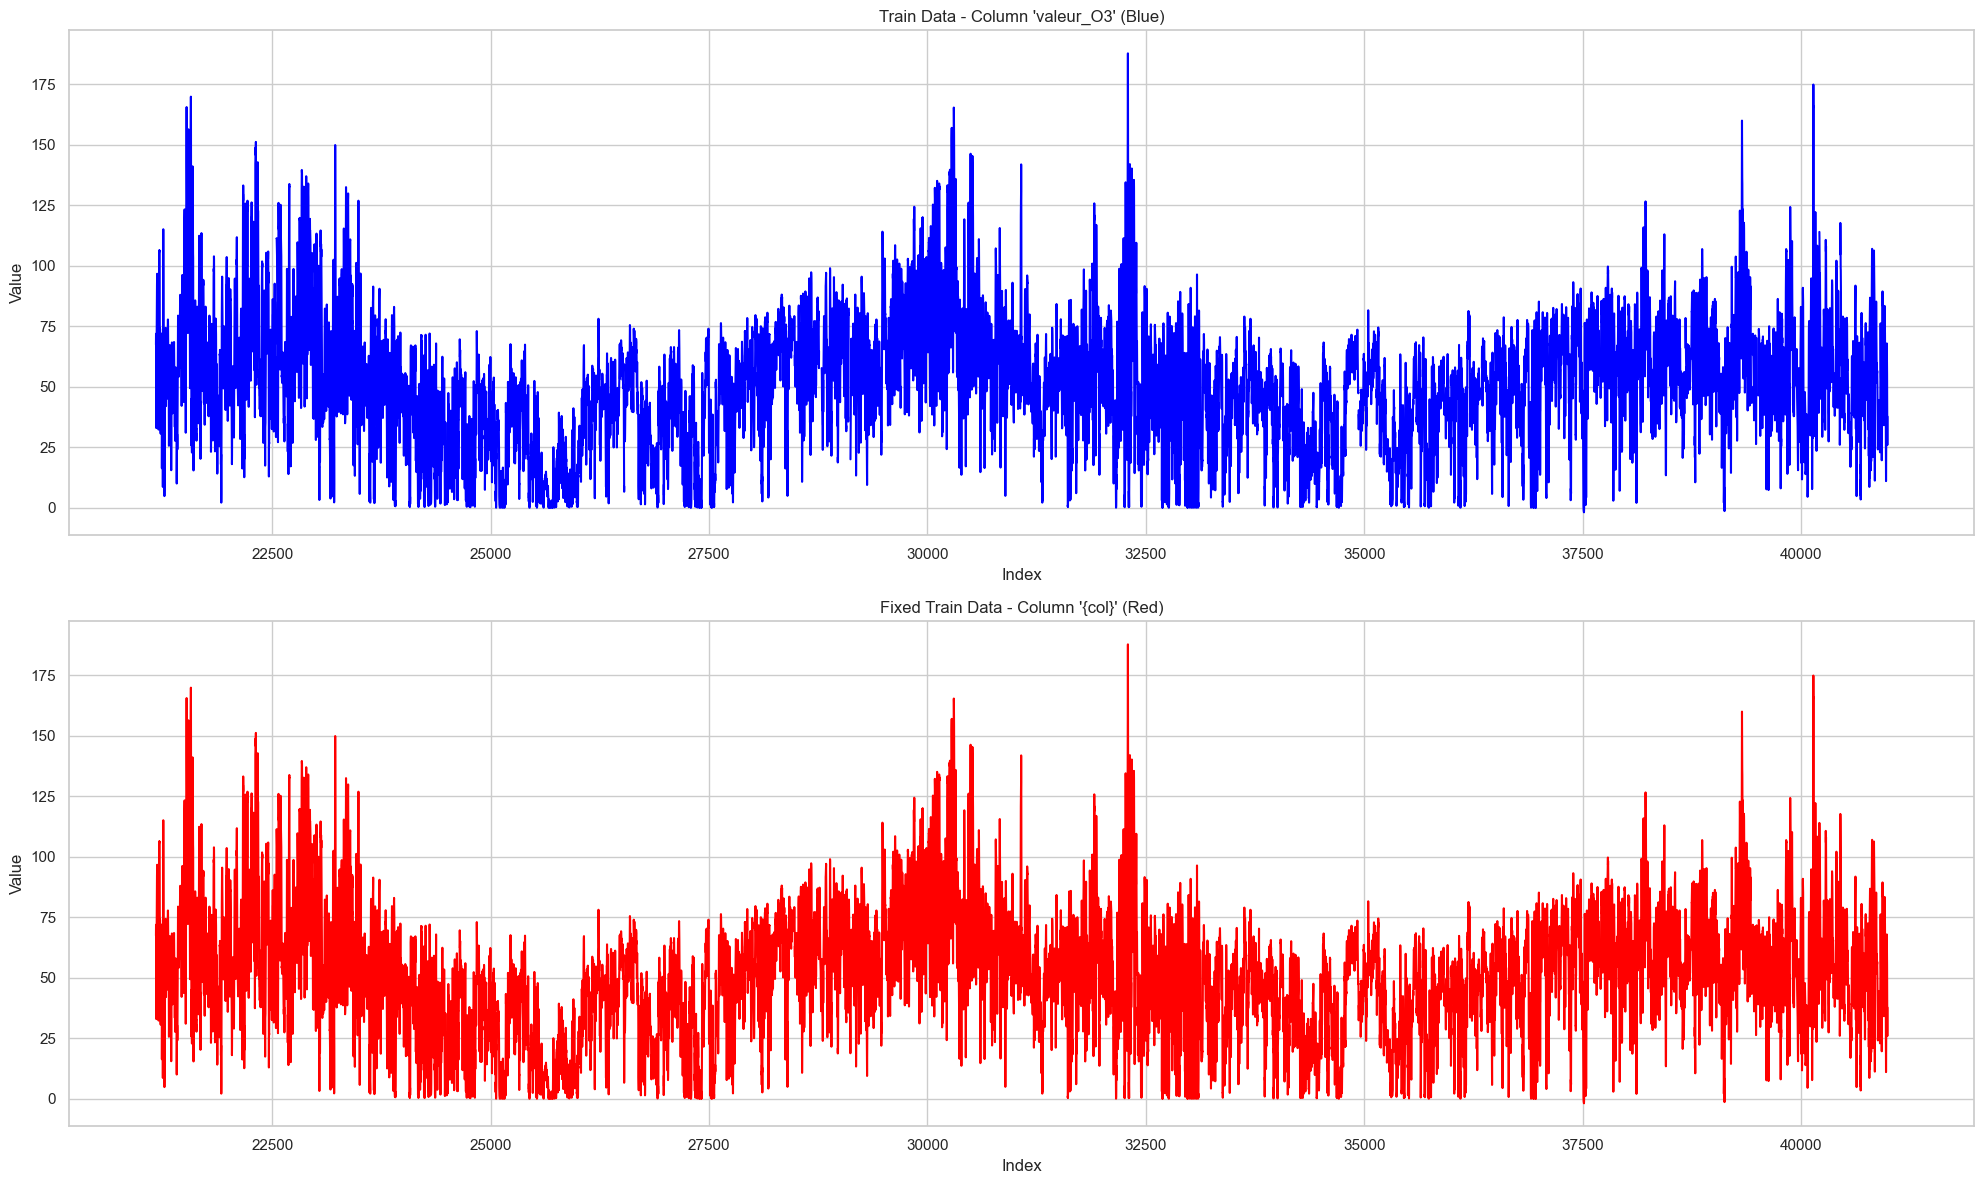

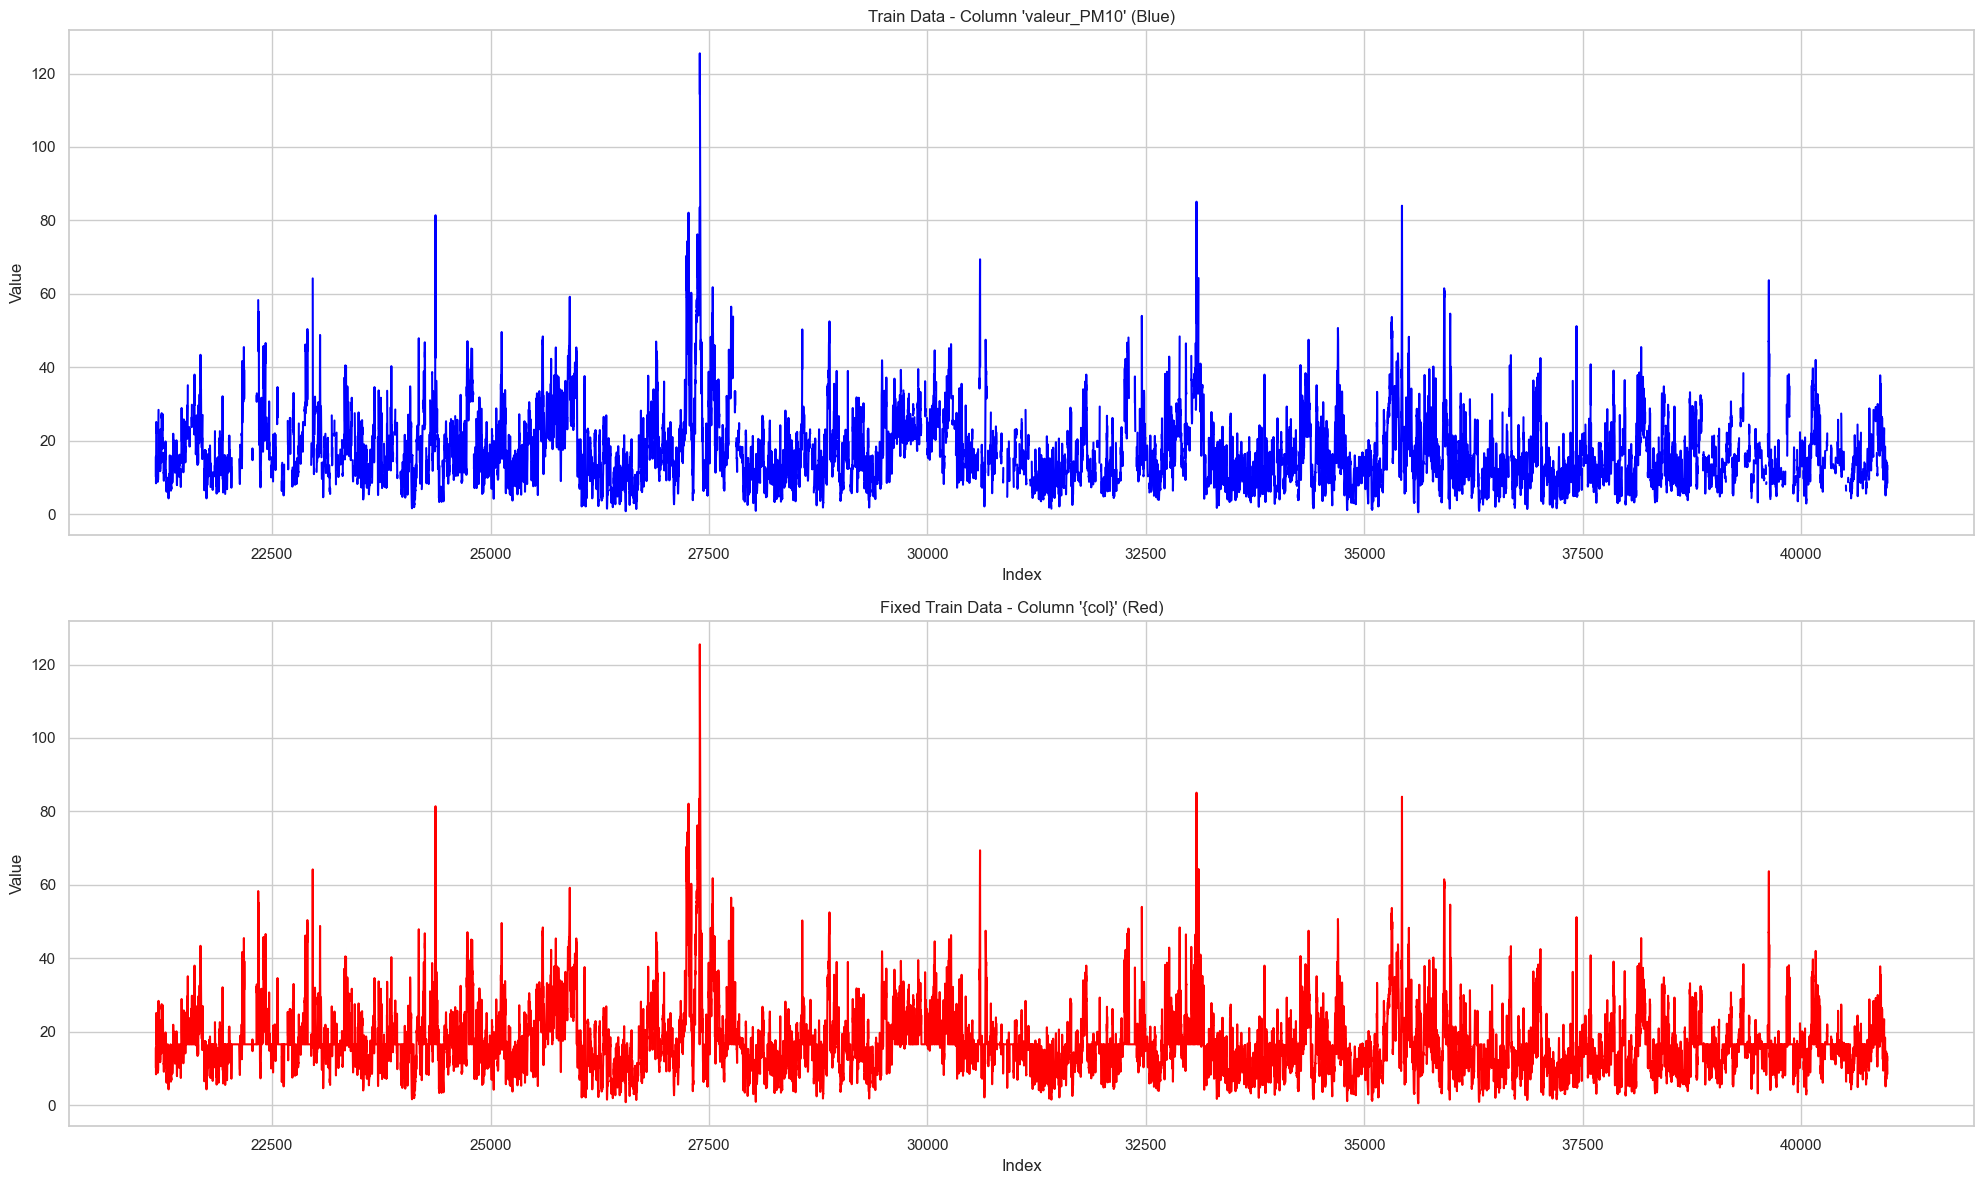

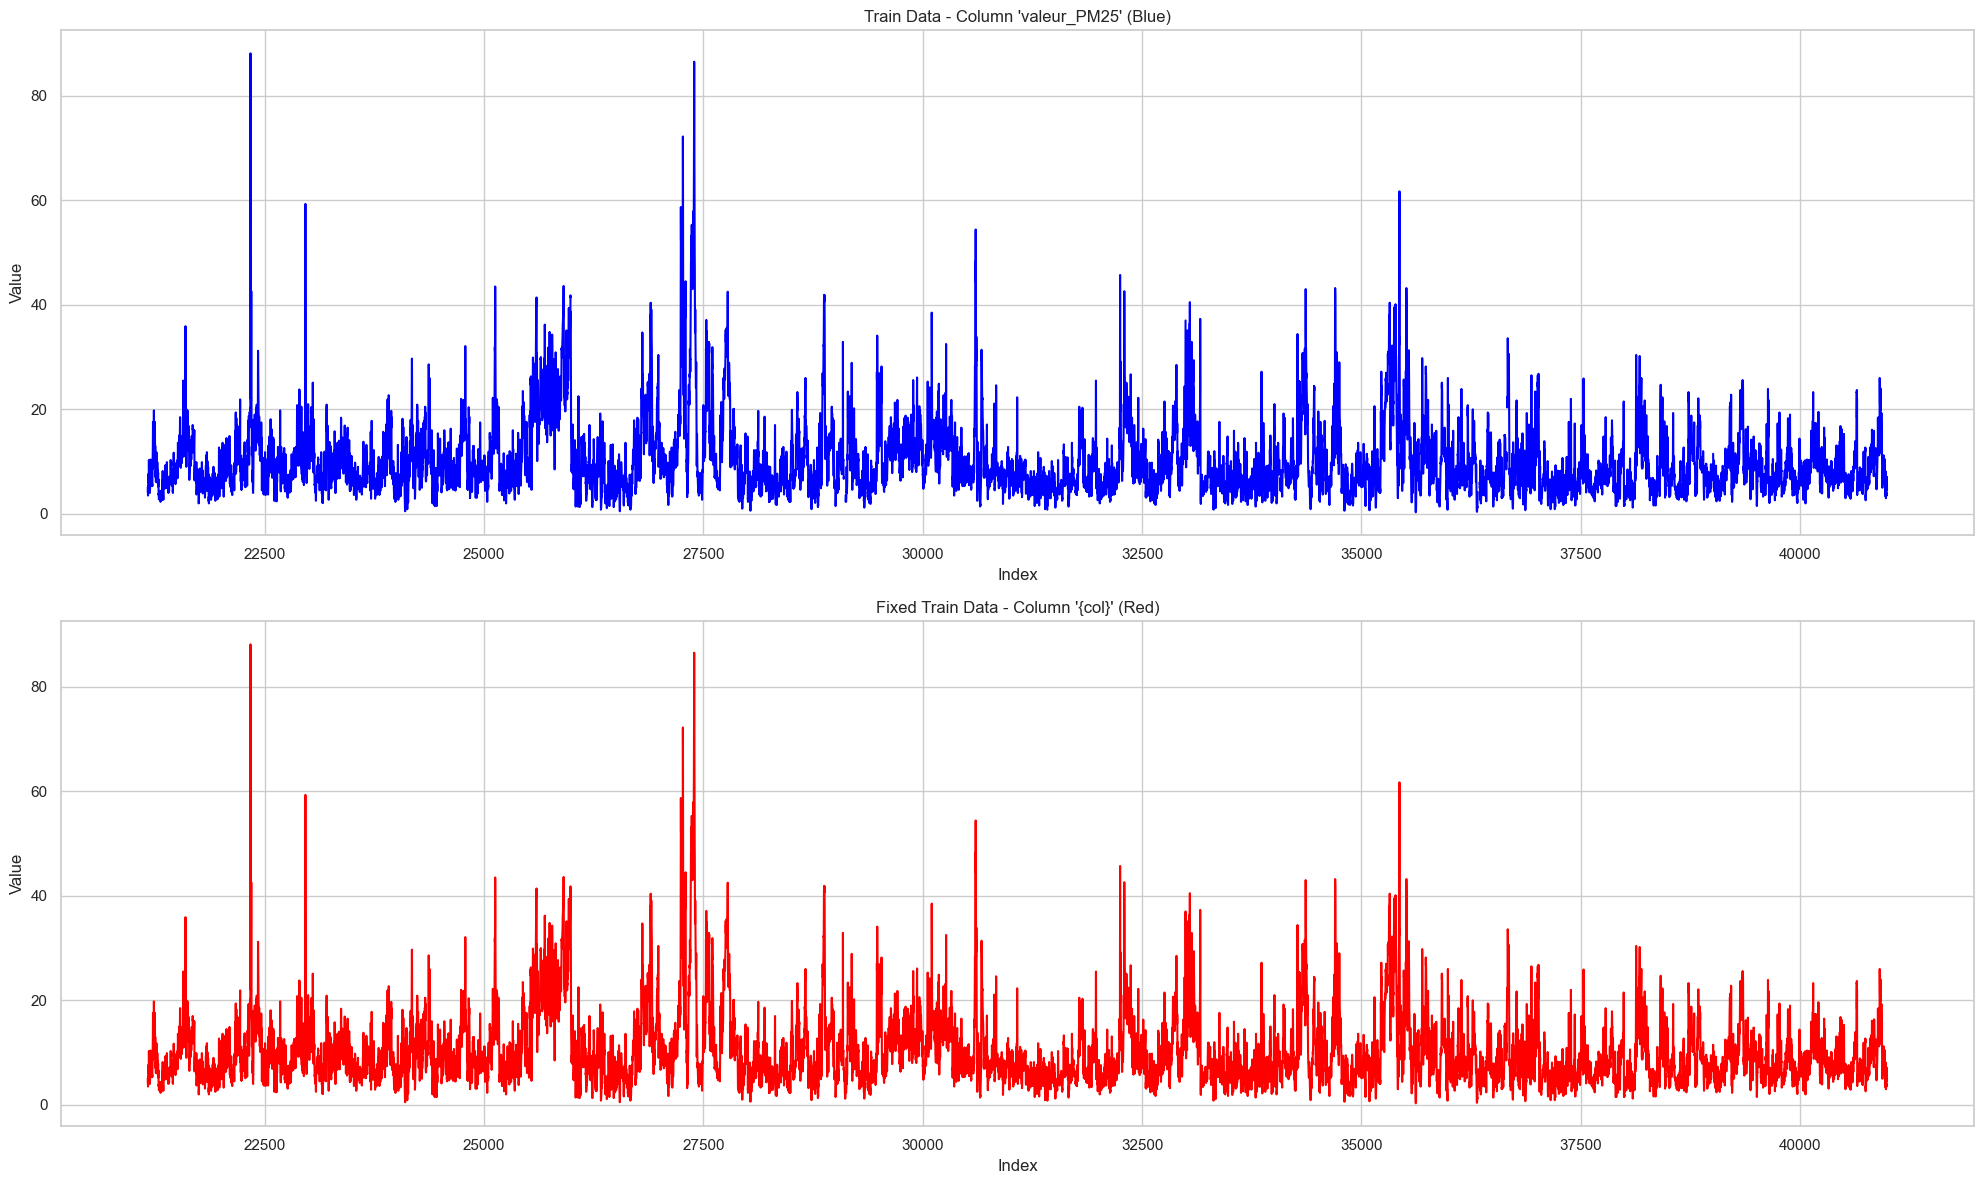

In [100]:
check_filling_result(df=train_df, fixed_df=fixed_train_df)

much better

In [102]:
m = fixed_train_df[cols]<0
m.sum()

valeur_NO2      0
valeur_CO       0
valeur_O3      10
valeur_PM10     0
valeur_PM25     0
dtype: int64

there's negative values in O3, however, according to the figure above, they are quite close to 0, we can directly set them to 0

In [110]:
fixed_train_df.loc[fixed_train_df['valeur_O3']<0, 'valeur_O3'] = 0
(fixed_train_df['valeur_O3']<0).sum()
# no negative values 

np.int64(0)

In [114]:
fixed_train_df.to_csv("../data/fixed_train.csv", index=False)

end


In [ ]:
# Scaling/Normalization

# Select features for scaling (all pollutant columns and lags)
scaler = StandardScaler()
pollutant_columns = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25'] 
pollutant_columns = pollutant_columns + [f'{col}_lag_{lag}' for col in pollutant_columns for lag in lags]
train_df[pollutant_columns] = scaler.fit_transform(train_df[pollutant_columns])

# Weather

In [6]:
# Adding External Weather Data

# Define the time period for which we need the data
start_date = train_df.index.min()
end_date = train_df.index.max()

# Define the location (Paris coordinates)
paris = Point(48.8566, 2.3522)

# Fetch daily historical data for Paris from Meteostat
weather_data = Daily(paris, start_date, end_date)
weather_data = weather_data.fetch()

# Display the first few rows of the weather data
print(weather_data.head())

            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  pres  tsun
time                                                                  
1900-01-01   NaN   4.5  10.1   0.0   NaN   NaN   NaN   NaN   NaN   NaN
1900-01-02   NaN   7.9  12.0   7.5   NaN   NaN   NaN   NaN   NaN   NaN
1900-01-03   NaN   6.0   9.3   2.2   NaN   NaN   NaN   NaN   NaN   NaN
1900-01-04   NaN   6.0   8.3   3.1   NaN   NaN   NaN   NaN   NaN   NaN
1900-01-05   NaN   2.2   6.0   0.0   NaN   NaN   NaN   NaN   NaN   NaN


In [7]:
# Reset index in `weather_data` to use the date as a regular column
weather_data = weather_data.reset_index()
weather_data['weather_time'] = weather_data['time'].dt.floor('D')  # Convert to daily frequency

train_df = train_df.reset_index()
train_df['air_quality_time'] = train_df['id'].dt.floor('D')

# Merge the weather data with your air quality data
merged_df = pd.merge(train_df, weather_data, left_on='air_quality_time', right_on='weather_time', how='left')

# Drop unnecessary columns and clean up
merged_df = merged_df.drop(columns=['air_quality_time', 'weather_time'])

# Save the combined DataFrame to a new CSV file
merged_df.to_csv('../data/train_with_weather.csv', index=False)

In [8]:
merged_df

,index,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,0,2020-01-01 00:00:00,42.9,0.718,15.7,73.1,64.4,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN
1,1,2020-01-01 01:00:00,33.6,0.587,10.1,74.8,66.0,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN
2,2,2020-01-01 02:00:00,29.3,NaN,5.1,51.0,44.9,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN
3,3,2020-01-01 03:00:00,30.5,0.246,7.2,27.7,25.1,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN
4,4,2020-01-01 04:00:00,29.3,0.204,8.3,15.3,13.6,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40986,40986,2024-09-03 18:00:00,NaN,0.222,55.1,12.0,5.3,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN
40987,40987,2024-09-03 19:00:00,NaN,0.245,48.2,13.4,7.0,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN
40988,40988,2024-09-03 20:00:00,NaN,0.234,44.5,12.4,7.1,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN
40989,40989,2024-09-03 21:00:00,NaN,0.225,25.9,10.6,5.4,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN


# French Holidays

In [9]:
# Initialize SchoolHolidayDates
d = SchoolHolidayDates()

# Collect holiday dates for Zone C from 2020 to 2024
holiday_list = []
for year in range(2020, 2025):  # Loop through each year
    holidays_for_year = d.holidays_for_year_and_zone(year, 'C')
    for date in holidays_for_year.keys():
        holiday_list.append({'holiday_date': pd.to_datetime(date), 'is_holiday_zone_c': True})

# Create a DataFrame from the collected holiday dates
holiday_dates_zone_c = pd.DataFrame(holiday_list)

In [10]:
# Check that holiday_dates_zone_c has the 'is_holiday_zone_c' column
print(holiday_dates_zone_c.columns)  # Should include 'holiday_date' and 'is_holiday_zone_c'

# Merge holiday information with train data
merged_df_2 = pd.merge(merged_df, holiday_dates_zone_c, left_on='time', right_on='holiday_date', how='left')

# If 'is_holiday_zone_c' is missing after the merge, default to False
if 'is_holiday_zone_c' not in merged_df_2.columns:
    merged_df_2['is_holiday_zone_c'] = False
else:
    # Fill NaN in 'is_holiday_zone_c' with False
    merged_df_2['is_holiday_zone_c'] = merged_df_2['is_holiday_zone_c'].fillna(False)

# Drop unnecessary columns
merged_df_2 = merged_df_2.drop(columns=['air_quality_time', 'holiday_date','index'], errors='ignore')

# Display the merged DataFrame
merged_df_2

Index(['holiday_date', 'is_holiday_zone_c'], dtype='object')


,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,is_holiday_zone_c
0,2020-01-01 00:00:00,42.9,0.718,15.7,73.1,64.4,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True
1,2020-01-01 01:00:00,33.6,0.587,10.1,74.8,66.0,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True
2,2020-01-01 02:00:00,29.3,NaN,5.1,51.0,44.9,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True
3,2020-01-01 03:00:00,30.5,0.246,7.2,27.7,25.1,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True
4,2020-01-01 04:00:00,29.3,0.204,8.3,15.3,13.6,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40986,2024-09-03 18:00:00,NaN,0.222,55.1,12.0,5.3,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN,False
40987,2024-09-03 19:00:00,NaN,0.245,48.2,13.4,7.0,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN,False
40988,2024-09-03 20:00:00,NaN,0.234,44.5,12.4,7.1,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN,False
40989,2024-09-03 21:00:00,NaN,0.225,25.9,10.6,5.4,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN,False


# Jours Feries

In [11]:
# Initialize French holidays for the range of years needed
france_holidays = holidays.France(years=range(2020, 2025))

# Assume merged_df_2 is already created and has an 'id' column with datetime values
# Convert 'id' to date-only format for easier holiday matching
merged_df_2['date_only'] = merged_df_2['time'].dt.floor('D')

# Add a new column in merged_df_2 to indicate if each date is a public holiday in France
merged_df_2['is_public_holiday'] = merged_df_2['date_only'].apply(lambda date: date in france_holidays)

# Create merged_df_3 by dropping the 'date_only' column after merging the holiday information
merged_df_3 = merged_df_2.drop(columns=['date_only'])

# Display the final merged DataFrame
merged_df_3

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,is_holiday_zone_c,is_public_holiday
0,2020-01-01 00:00:00,42.9,0.718,15.7,73.1,64.4,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True,True
1,2020-01-01 01:00:00,33.6,0.587,10.1,74.8,66.0,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True,True
2,2020-01-01 02:00:00,29.3,NaN,5.1,51.0,44.9,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True,True
3,2020-01-01 03:00:00,30.5,0.246,7.2,27.7,25.1,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True,True
4,2020-01-01 04:00:00,29.3,0.204,8.3,15.3,13.6,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40986,2024-09-03 18:00:00,NaN,0.222,55.1,12.0,5.3,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN,False,False
40987,2024-09-03 19:00:00,NaN,0.245,48.2,13.4,7.0,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN,False,False
40988,2024-09-03 20:00:00,NaN,0.234,44.5,12.4,7.1,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN,False,False
40989,2024-09-03 21:00:00,NaN,0.225,25.9,10.6,5.4,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN,False,False


# Lockdown

In [12]:
lockdown_periods = [
    (pd.Timestamp(year=2020, month=3, day=12).date(), pd.Timestamp(year=2020, month=5, day=10).date()),
    (pd.Timestamp(year=2020, month=10, day=14).date(), pd.Timestamp(year=2020, month=12, day=10).date()),
    (pd.Timestamp(year=2021, month=3, day=31).date(), pd.Timestamp(year=2021, month=5, day=2).date())
]

# Add a 'lockdown' column with True if the date falls within any lockdown period, False otherwise
merged_df_3['lockdown'] = merged_df_3['time'].apply(
    lambda i: any(start <= i.date() <= end for start, end in lockdown_periods)
)

# Display the modified DataFrame
merged_df_3

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,is_holiday_zone_c,is_public_holiday,lockdown
0,2020-01-01 00:00:00,42.9,0.718,15.7,73.1,64.4,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True,True,False
1,2020-01-01 01:00:00,33.6,0.587,10.1,74.8,66.0,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True,True,False
2,2020-01-01 02:00:00,29.3,NaN,5.1,51.0,44.9,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True,True,False
3,2020-01-01 03:00:00,30.5,0.246,7.2,27.7,25.1,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True,True,False
4,2020-01-01 04:00:00,29.3,0.204,8.3,15.3,13.6,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40986,2024-09-03 18:00:00,NaN,0.222,55.1,12.0,5.3,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False
40987,2024-09-03 19:00:00,NaN,0.245,48.2,13.4,7.0,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False
40988,2024-09-03 20:00:00,NaN,0.234,44.5,12.4,7.1,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False
40989,2024-09-03 21:00:00,NaN,0.225,25.9,10.6,5.4,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False


In [13]:
merged_df_3

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,is_holiday_zone_c,is_public_holiday,lockdown
0,2020-01-01 00:00:00,42.9,0.718,15.7,73.1,64.4,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True,True,False
1,2020-01-01 01:00:00,33.6,0.587,10.1,74.8,66.0,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True,True,False
2,2020-01-01 02:00:00,29.3,NaN,5.1,51.0,44.9,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True,True,False
3,2020-01-01 03:00:00,30.5,0.246,7.2,27.7,25.1,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True,True,False
4,2020-01-01 04:00:00,29.3,0.204,8.3,15.3,13.6,2020-01-01,2.4,-0.8,4.6,0.0,NaN,162.0,7.8,22.0,1031.4,NaN,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40986,2024-09-03 18:00:00,NaN,0.222,55.1,12.0,5.3,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False
40987,2024-09-03 19:00:00,NaN,0.245,48.2,13.4,7.0,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False
40988,2024-09-03 20:00:00,NaN,0.234,44.5,12.4,7.1,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False
40989,2024-09-03 21:00:00,NaN,0.225,25.9,10.6,5.4,2024-09-03,20.0,18.2,21.6,0.3,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False


# Weekend

In [14]:
# Add a new column indicating if the date is a weekend day ("Saturday" or "Sunday") or not
merged_df_3['is_weekend'] = merged_df_3['time'].apply(lambda x: x.weekday() >= 5)

# Display the modified DataFrame
merged_df_3

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,time,tavg,tmin,tmax,...,snow,wdir,wspd,wpgt,pres,tsun,is_holiday_zone_c,is_public_holiday,lockdown,is_weekend
0,2020-01-01 00:00:00,42.9,0.718,15.7,73.1,64.4,2020-01-01,2.4,-0.8,4.6,...,NaN,162.0,7.8,22.0,1031.4,NaN,True,True,False,False
1,2020-01-01 01:00:00,33.6,0.587,10.1,74.8,66.0,2020-01-01,2.4,-0.8,4.6,...,NaN,162.0,7.8,22.0,1031.4,NaN,True,True,False,False
2,2020-01-01 02:00:00,29.3,NaN,5.1,51.0,44.9,2020-01-01,2.4,-0.8,4.6,...,NaN,162.0,7.8,22.0,1031.4,NaN,True,True,False,False
3,2020-01-01 03:00:00,30.5,0.246,7.2,27.7,25.1,2020-01-01,2.4,-0.8,4.6,...,NaN,162.0,7.8,22.0,1031.4,NaN,True,True,False,False
4,2020-01-01 04:00:00,29.3,0.204,8.3,15.3,13.6,2020-01-01,2.4,-0.8,4.6,...,NaN,162.0,7.8,22.0,1031.4,NaN,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40986,2024-09-03 18:00:00,NaN,0.222,55.1,12.0,5.3,2024-09-03,20.0,18.2,21.6,...,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False,False
40987,2024-09-03 19:00:00,NaN,0.245,48.2,13.4,7.0,2024-09-03,20.0,18.2,21.6,...,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False,False
40988,2024-09-03 20:00:00,NaN,0.234,44.5,12.4,7.1,2024-09-03,20.0,18.2,21.6,...,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False,False
40989,2024-09-03 21:00:00,NaN,0.225,25.9,10.6,5.4,2024-09-03,20.0,18.2,21.6,...,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False,False


In [15]:
# Target Variable Extraction

train_processed = pd.read_csv('../data/train_with_weather.csv')

target_columns = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']

# Separate features and target for training
X_train = train_processed.drop(columns=target_columns)
y_train = train_processed[target_columns]

# Test set only has features, as targets are unknown
X_test = test_df.reset_index()

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (40991, 13)
y_train shape: (40991, 5)
X_test shape: (504, 2)


Need to do the same preprocessing for X_test to get the same columns as X_train